<a href="https://colab.research.google.com/github/donmarcolaureano/predictionofproductsales/blob/main/Preprocessed%20Data%20for%20ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data and imports

In [223]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output='pandas')

In [118]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
# Custom function
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics
def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )
  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)


In [120]:
# Custom function
def plot_coeffs(coeffs, top_n=None, figsize=(4,5),
                intercept=False, intercept_name="intercept",
                annotate=False, ha='left', va='center', size=12,
                xytext=(4,0), textcoords='offset points'):

    # Drop intercept if intercept=False and
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)

        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient',
            ylabel='Feature Names',
            title=title)
    ax.axvline(0, color='k')
    if annotate == True:
        annotate_hbars(ax, ha=ha, va=va, size=size, xytext=xytext, textcoords=textcoords)
    return ax

In [121]:
# Custom function
def annotate_hbars(ax, ha='left', va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:

        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha, va=va, size=size,
                        xytext=xytext, textcoords=textcoords)

In [122]:
# Custom importances
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):

    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_

    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)

    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)

    return importances

In [123]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

In [124]:
# Data
df = pd.read_csv('/content/drive/MyDrive/CodingDojo/01-Fundamentals/Week02/Data/sales_predictions_2023.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.02,Dairy,249.81,OUT049,1999,Medium,Tier 1,Supermarket Type1,"3,735.14"
1,DRC01,5.92,Regular,0.02,Soft Drinks,48.27,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.42
2,FDN15,17.50,Low Fat,0.02,Meat,141.62,OUT049,1999,Medium,Tier 1,Supermarket Type1,"2,097.27"
3,FDX07,19.20,Regular,0.00,Fruits and Vegetables,182.09,OUT010,1998,NaN,Tier 3,Grocery Store,732.38
4,NCD19,8.93,Low Fat,0.00,Household,53.86,OUT013,1987,High,Tier 3,Supermarket Type1,994.71


# EDA

In [125]:
# Dtypes
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [126]:
# Duplicated rows
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
8518    False
8519    False
8520    False
8521    False
8522    False
Length: 8523, dtype: bool

In [127]:
# Null values
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [128]:
# make copy of original df to avoid any manipulations
eda_df = df.copy()

In [129]:
# drop unnecessary columns
eda_df = eda_df.drop('Item_Identifier', axis=1)

In [130]:
# display first 5 rows

eda_df.head(5)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.02,Dairy,249.81,OUT049,1999,Medium,Tier 1,Supermarket Type1,"3,735.14"
1,5.92,Regular,0.02,Soft Drinks,48.27,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.42
2,17.50,Low Fat,0.02,Meat,141.62,OUT049,1999,Medium,Tier 1,Supermarket Type1,"2,097.27"
3,19.20,Regular,0.00,Fruits and Vegetables,182.09,OUT010,1998,NaN,Tier 3,Grocery Store,732.38
4,8.93,Low Fat,0.00,Household,53.86,OUT013,1987,High,Tier 3,Supermarket Type1,994.71


# Define Target & Features and Train Test Split

In [131]:
# define target and featgures
target = 'Item_Outlet_Sales'
y = eda_df[target]
X = eda_df.drop(columns=[target, 'Item_Outlet_Sales'])

In [132]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [133]:
# Inspect X_train
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6392 entries, 4776 to 7270
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                5285 non-null   float64
 1   Item_Fat_Content           6392 non-null   object 
 2   Item_Visibility            6392 non-null   float64
 3   Item_Type                  6392 non-null   object 
 4   Item_MRP                   6392 non-null   float64
 5   Outlet_Identifier          6392 non-null   object 
 6   Outlet_Establishment_Year  6392 non-null   int64  
 7   Outlet_Size                4580 non-null   object 
 8   Outlet_Location_Type       6392 non-null   object 
 9   Outlet_Type                6392 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 549.3+ KB


# Create 3 Pipelines

## Ordinal

In [134]:
# Save list
ord_cols = ['Outlet_Size']

In [135]:
# Impute null values usting strategy most_frequent
impute_na_ord = SimpleImputer(strategy = 'most_frequent')

In [136]:
# ordinal encoder for outlet size
size_order = ['Small', 'Medium', 'High']
size_encoder = OrdinalEncoder(categories=[size_order])
size_encoder

OrdinalEncoder(categories=[['Small', 'Medium', 'High']])

In [137]:
# Scaler
scaler = StandardScaler()

In [138]:
# pipeline
ord_pipeline = make_pipeline(impute_na_ord, size_encoder, scaler)
ord_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['Small', 'Medium', 'High']])),
                ('standardscaler', StandardScaler())])

In [139]:
# ordinal tuple
ord_tuple = ('ordinal', ord_pipeline, ord_cols)
ord_tuple

('ordinal',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Small', 'Medium', 'High']])),
                 ('standardscaler', StandardScaler())]),
 ['Outlet_Size'])

## Numerical

In [140]:
# save list of numeric features
num_cols = X_train.select_dtypes('number').columns
num_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')

In [141]:
# impute nan values with SimpleImputer strategy median
impute_mean = SimpleImputer(strategy='mean')

In [142]:
# Scaler
scaler = StandardScaler()

In [143]:
# make pipeline
num_pipe = make_pipeline(impute_mean, scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [144]:
# numerical tuple
num_tuple = ('numeric', num_pipe, num_cols)
num_tuple

('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer()),
                 ('standardscaler', StandardScaler())]),
 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
        'Outlet_Establishment_Year'],
       dtype='object'))

## Categorical

In [145]:
# Save list of nominal features
cat_cols = X_train.select_dtypes('object').drop(columns=ord_cols).columns
cat_cols

Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [146]:
# OneHotEncoder
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [147]:
# Pipeline
cat_pipe = make_pipeline(ohe_encoder)
cat_pipe

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [148]:
# Categorical tuple
cat_tuple = ('categorical', cat_pipe, cat_cols)
cat_tuple

('categorical',
 Pipeline(steps=[('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
        'Outlet_Location_Type', 'Outlet_Type'],
       dtype='object'))

# Column Transformer

In [149]:
# Instantiate column transformer
col_transformer = ColumnTransformer ([num_tuple, cat_tuple, ord_tuple], verbose_feature_names_out=False)
col_transformer

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'High']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size'])],
                  verbose_feature_names_out=False)

In [150]:
# Fit the column transformer
col_transformer.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'High']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size'])],
                  verbose_feature_names_out=False)

In [151]:
# Save transformed data
X_train_processed = col_transformer.transform(X_train)
X_train_processed.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,...,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size
4776,0.82,-0.71,1.83,1.33,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.29
7510,0.56,-1.29,0.60,1.33,0.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.29
5828,-0.13,1.81,0.24,0.14,0.00,0.00,1.00,0.00,0.00,0.00,...,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.29
5327,-1.17,-1.00,-0.95,0.73,0.00,1.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,-1.38
4810,1.53,-0.97,-0.34,0.49,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.29


In [152]:
#Process X_test
X_test_processed = col_transformer.transform(X_test)
X_test_processed.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,...,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size
7503,0.33,-0.78,-1.00,-1.29,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.96
2957,-1.18,0.10,-1.59,-0.10,0.00,1.00,0.00,0.00,0.00,0.00,...,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,-1.38
7031,0.38,-0.48,-1.60,0.14,0.00,0.00,1.00,0.00,0.00,0.00,...,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.29
1084,0.00,-0.42,0.51,-1.53,0.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.29
856,-0.64,-1.05,0.89,0.73,0.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,-1.38


# CRISP-DM Phase 4 - Modeling

## Linear Regression Model

In [153]:
# Instantiate model
lin_reg = LinearRegression()
lin_reg

LinearRegression()

In [154]:
# fit on training data
lin_reg.fit(X_train_processed, y_train)

LinearRegression()

In [155]:
# Get predictions for training data
y_preds_train = lin_reg.predict(X_train_processed)
# Get predictions for the testing data
y_preds_test = lin_reg.predict(X_test_processed)

In [156]:
# Evaluate model
evaluate_regression(lin_reg, X_train_processed, y_train, X_test_processed, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.154
- MSE = 1,297,212.367
- RMSE = 1,138.952
- R^2 = 0.562

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 804.225
- MSE = 1,194,696.265
- RMSE = 1,093.022
- R^2 = 0.567


This model is very underfit. The R^2 shows that it can only explain ~57% of the variation in the target

## Random Forest Model

In [157]:
# Instantiate default random forest model
rf = RandomForestRegressor(random_state=42)

In [158]:
# Model pipeline
rf_pipe = make_pipeline(col_transformer, rf)

In [159]:
# fit pipeline on training data
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',...
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Small',
                                                                                               'Medium',
                                                                                               'High']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Outlet_Size'])],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [160]:
# Evaluate
evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 296.833
- MSE = 182,935.361
- RMSE = 427.709
- R^2 = 0.938

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 763.708
- MSE = 1,213,209.449
- RMSE = 1,101.458
- R^2 = 0.560


The Random Forest model did significantly better than the Linear Regression model on the training data but did slightly worse on the testing data

## GridSearchCV for tuning

In [161]:
# Parameters for tuning
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
          'Outlet_Establishment_Year'],
         dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse_output=False))]),
                                    Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
          'Outlet_Location_Type', 'Outlet_Type'],
         

In [162]:
# define param grid with options to try
params = {'randomforestregressor__max_features': [1, 2, 3, 4, 5, 6, 7, 8], 'randomforestregressor__min_samples_leaf': [1, 2, 3], 'randomforestregressor__min_samples_split': [1, 2, 3]}

In [163]:
# Instantiate the gridsearch
gridsearch = GridSearchCV(rf_pipe, params, n_jobs = -1, cv = 4, verbose = 1)

In [164]:
# Fit gridsearch on training data
gridsearch.fit(X_train, y_train)

Fitting 4 folds for each of 72 candidates, totalling 288 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
96 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
96 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packa

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEnco...
                                                                                                                      'High']])),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Outlet_Size'])],
                                                          verbose_feature_names_out=False)),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_features': [1, 2, 3, 4, 5,
                                                                 6, 7, 8],
                         'randomforestregressor__min_samples_leaf': [1, 2, 3],
                         'randomforestregressor__min_samples_split': [1, 2, 3]},
             verbose=1)

In [165]:
# Obtain best parameters
gridsearch.best_params_

{'randomforestregressor__max_features': 8,
 'randomforestregressor__min_samples_leaf': 3,
 'randomforestregressor__min_samples_split': 2}

In [166]:
# define and refit best model
best_rf = gridsearch.best_estimator_
evaluate_regression(best_rf, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 612.300
- MSE = 760,039.172
- RMSE = 871.802
- R^2 = 0.743

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 745.397
- MSE = 1,123,885.344
- RMSE = 1,060.135
- R^2 = 0.593


# CRISP-DM Phase 5

Based off of the different models, I would recommend using the tuned Random Forest model as it outperformed both the Linear Regression and default Random Forest model on MAE, MSE, RMSE, and R^2 for the testing data
- Despite the Linear Regression model and Default Random Forest model having large differences in the training data, they both performed fairly similar on the test data
- The tuned Random Forest model is very comparable to the Default Random Forest model in many ways. The Default model actually outperformed the Tuned model in the training data but fell short on the data that mattered, the test data.

The R^2 metric is very important. It shows that the model can explain a specific % of the data.
- The Linear Regression model can explain ~57% of the test data
- The Default Random Forest model can explain 56% of the test data
- The Tuned Random Forest model can explain for 59% of the test data


We will also look at the RMSE to compare the differences in models
- The Linear Regression model had an RMSE of 1093.022
- The Default Random Forest model has an RMSE of 1101.458
- The Tuned Random Forest model had an RMSE of 1063.506
  - RMSE was -37.952 from the Default Random Forest model
  - RMSE was -29.516 from the Linear Regression model

Every model is underfit but the Tuned Random Forest model is the least underfit of the three models we compared and it performed better for all the metrics on the testing data.

This is a starting point and there is always room for improvement through adding more data, increasing complexity, or adding features with higher correlations to the target

# Revisit Models

In [167]:
SEED = 321
np.random.seed(SEED)
from sklearn.inspection import permutation_importance

In [168]:
# Get feature names
feature_names = col_transformer.get_feature_names_out()
feature_names

array(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Fat_Content_LF',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Item_Fat_Content_low fat', 'Item_Fat_Content_reg',
       'Item_Type_Baking Goods', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT010', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018',
       'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027',
       'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045',
       'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049',
       'Outlet_Lo

In [169]:
# Remake X_train and X_test as DataFrames with new feature names
X_train_2 = pd.DataFrame(col_transformer.transform(X_train),columns = feature_names, index = X_train.index)
X_test_2 = pd.DataFrame(col_transformer.transform(X_test), columns= feature_names, index = X_test.index)

In [170]:
X_train_2.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,...,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size
4776,0.82,-0.71,1.83,1.33,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.29
7510,0.56,-1.29,0.60,1.33,0.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.29
5828,-0.13,1.81,0.24,0.14,0.00,0.00,1.00,0.00,0.00,0.00,...,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.29


In [171]:
X_test_2.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,...,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size
7503,0.33,-0.78,-1.00,-1.29,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.96
2957,-1.18,0.10,-1.59,-0.10,0.00,1.00,0.00,0.00,0.00,0.00,...,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,-1.38
7031,0.38,-0.48,-1.60,0.14,0.00,0.00,1.00,0.00,0.00,0.00,...,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.29


### Tree Based Model

In [172]:
reg_seed = RandomForestRegressor(random_state=SEED)
reg_seed.fit(X_train_2, y_train)
evaluate_regression(reg_seed, X_train_2, y_train, X_test_2, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 297.885
- MSE = 183,458.648
- RMSE = 428.321
- R^2 = 0.938

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 767.654
- MSE = 1,217,538.621
- RMSE = 1,103.421
- R^2 = 0.559


In [173]:
# Get Feature importances
reg_seed.feature_importances_

array([5.16832113e-02, 9.60471732e-02, 4.38233495e-01, 2.73535320e-02,
       3.41752926e-03, 6.33338376e-03, 6.25707219e-03, 1.70519691e-03,
       1.68939456e-03, 4.18829615e-03, 2.47581108e-03, 2.85962424e-03,
       4.26900171e-03, 6.38320192e-03, 5.76235991e-03, 7.55947787e-03,
       2.95837295e-03, 3.78933206e-03, 6.13602667e-03, 3.63732302e-03,
       1.56341704e-03, 1.74766231e-03, 8.31422126e-03, 5.63018047e-03,
       3.14457962e-03, 1.28815876e-05, 1.71353338e-03, 3.67188785e-03,
       1.20336672e-03, 1.58436153e-05, 2.68116835e-02, 4.00209734e-03,
       4.51138014e-03, 3.57462891e-03, 4.16470939e-03, 3.48577182e-03,
       3.09152990e-03, 2.94084796e-03, 1.91709016e-01, 1.79416087e-03,
       1.32596713e-03, 3.67647099e-02, 6.06710836e-03])

In [174]:
# Save the feature importances
tree_importances = pd.Series(reg_seed.feature_importances_, index = feature_names, name = 'Feature Importance')
tree_importances

Item_Weight                       0.05
Item_Visibility                   0.10
Item_MRP                          0.44
Outlet_Establishment_Year         0.03
Item_Fat_Content_LF               0.00
Item_Fat_Content_Low Fat          0.01
Item_Fat_Content_Regular          0.01
Item_Fat_Content_low fat          0.00
Item_Fat_Content_reg              0.00
Item_Type_Baking Goods            0.00
Item_Type_Breads                  0.00
Item_Type_Breakfast               0.00
Item_Type_Canned                  0.00
Item_Type_Dairy                   0.01
Item_Type_Frozen Foods            0.01
Item_Type_Fruits and Vegetables   0.01
Item_Type_Hard Drinks             0.00
Item_Type_Health and Hygiene      0.00
Item_Type_Household               0.01
Item_Type_Meat                    0.00
Item_Type_Others                  0.00
Item_Type_Seafood                 0.00
Item_Type_Snack Foods             0.01
Item_Type_Soft Drinks             0.01
Item_Type_Starchy Foods           0.00
Outlet_Identifier_OUT010 

In [194]:
# Saving the feature importances sorted from smallest to largest (ascending=True)
sorted_trees = tree_importances.sort_values()
sorted_trees

Outlet_Identifier_OUT010          0.00
Outlet_Identifier_OUT019          0.00
Outlet_Identifier_OUT018          0.00
Outlet_Type_Supermarket Type2     0.00
Item_Type_Others                  0.00
Item_Fat_Content_reg              0.00
Item_Fat_Content_low fat          0.00
Outlet_Identifier_OUT013          0.00
Item_Type_Seafood                 0.00
Outlet_Type_Supermarket Type1     0.00
Item_Type_Breads                  0.00
Item_Type_Breakfast               0.00
Outlet_Location_Type_Tier 3       0.00
Item_Type_Hard Drinks             0.00
Outlet_Location_Type_Tier 2       0.00
Item_Type_Starchy Foods           0.00
Item_Fat_Content_LF               0.00
Outlet_Location_Type_Tier 1       0.00
Outlet_Identifier_OUT046          0.00
Item_Type_Meat                    0.00
Outlet_Identifier_OUT017          0.00
Item_Type_Health and Hygiene      0.00
Outlet_Identifier_OUT035          0.00
Outlet_Identifier_OUT049          0.00
Item_Type_Baking Goods            0.00
Item_Type_Canned         

In [195]:
# Saving the feature importances sorted from smallest to largest (ascending=True)
sorted_importance = importances.sort_values()
sorted_importance


Outlet_Identifier_OUT010          0.00
Outlet_Identifier_OUT019          0.00
Outlet_Identifier_OUT018          0.00
Outlet_Type_Supermarket Type2     0.00
Item_Type_Others                  0.00
Item_Fat_Content_reg              0.00
Item_Fat_Content_low fat          0.00
Outlet_Identifier_OUT013          0.00
Item_Type_Seafood                 0.00
Outlet_Type_Supermarket Type1     0.00
Item_Type_Breads                  0.00
Item_Type_Breakfast               0.00
Outlet_Location_Type_Tier 3       0.00
Item_Type_Hard Drinks             0.00
Outlet_Location_Type_Tier 2       0.00
Item_Type_Starchy Foods           0.00
Item_Fat_Content_LF               0.00
Outlet_Location_Type_Tier 1       0.00
Outlet_Identifier_OUT046          0.00
Item_Type_Meat                    0.00
Outlet_Identifier_OUT017          0.00
Item_Type_Health and Hygiene      0.00
Outlet_Identifier_OUT035          0.00
Outlet_Identifier_OUT049          0.00
Item_Type_Baking Goods            0.00
Item_Type_Canned         

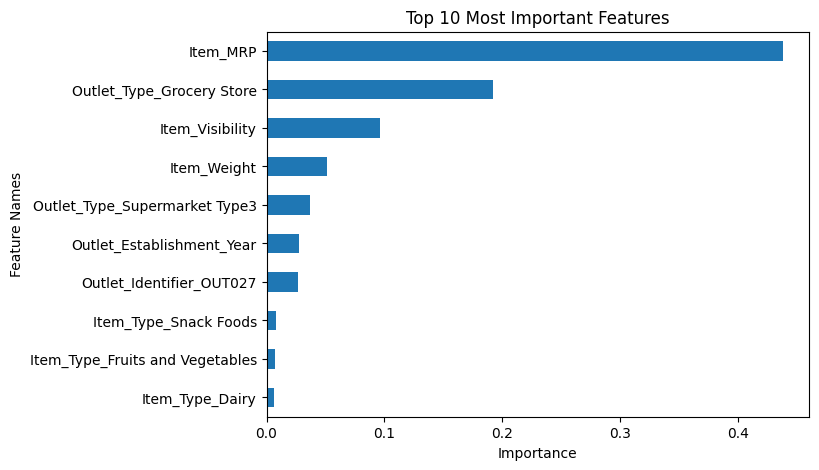

In [196]:
# Visualization of importances
ax = sorted_trees.tail(10).plot(kind='barh', figsize=(7,5),)
ax.set(xlabel='Importance',
        ylabel='Feature Names',
        title='Top 10 Most Important Features');

In [197]:
fig_ax = ax.get_figure()

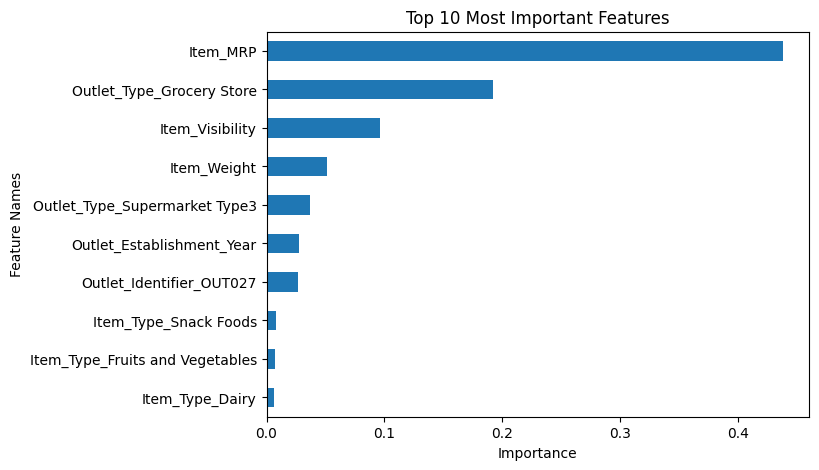

In [198]:
fig_ax

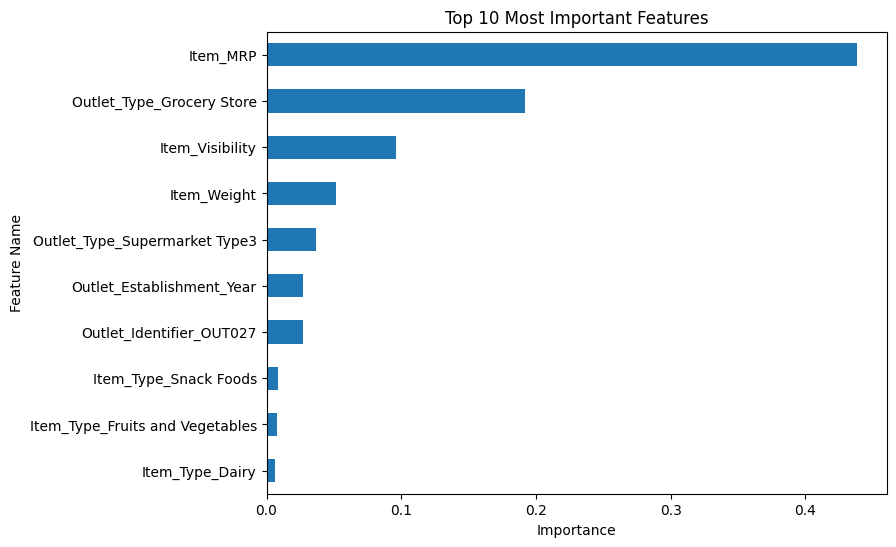

In [201]:
# Using plt.gcf to get the fig
ax = sorted_importance.tail(10).plot(kind='barh',
                                    figsize=(8,6), xlabel='Importance',
                                    ylabel='Feature Name',
                                    title='Top 10 Most Important Features')
fig_gcf = plt.gcf()

In [202]:
reg_seed.feature_names_in_

array(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Fat_Content_LF',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Item_Fat_Content_low fat', 'Item_Fat_Content_reg',
       'Item_Type_Baking Goods', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT010', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018',
       'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027',
       'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045',
       'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049',
       'Outlet_Lo

In [203]:
importances = get_importances(reg_seed,sort=True,ascending=False)
importances


Item_MRP                          0.44
Outlet_Type_Grocery Store         0.19
Item_Visibility                   0.10
Item_Weight                       0.05
Outlet_Type_Supermarket Type3     0.04
Outlet_Establishment_Year         0.03
Outlet_Identifier_OUT027          0.03
Item_Type_Snack Foods             0.01
Item_Type_Fruits and Vegetables   0.01
Item_Type_Dairy                   0.01
Item_Fat_Content_Low Fat          0.01
Item_Fat_Content_Regular          0.01
Item_Type_Household               0.01
Outlet_Size                       0.01
Item_Type_Frozen Foods            0.01
Item_Type_Soft Drinks             0.01
Outlet_Identifier_OUT045          0.00
Item_Type_Canned                  0.00
Item_Type_Baking Goods            0.00
Outlet_Identifier_OUT049          0.00
Outlet_Identifier_OUT035          0.00
Item_Type_Health and Hygiene      0.00
Outlet_Identifier_OUT017          0.00
Item_Type_Meat                    0.00
Outlet_Identifier_OUT046          0.00
Outlet_Location_Type_Tier

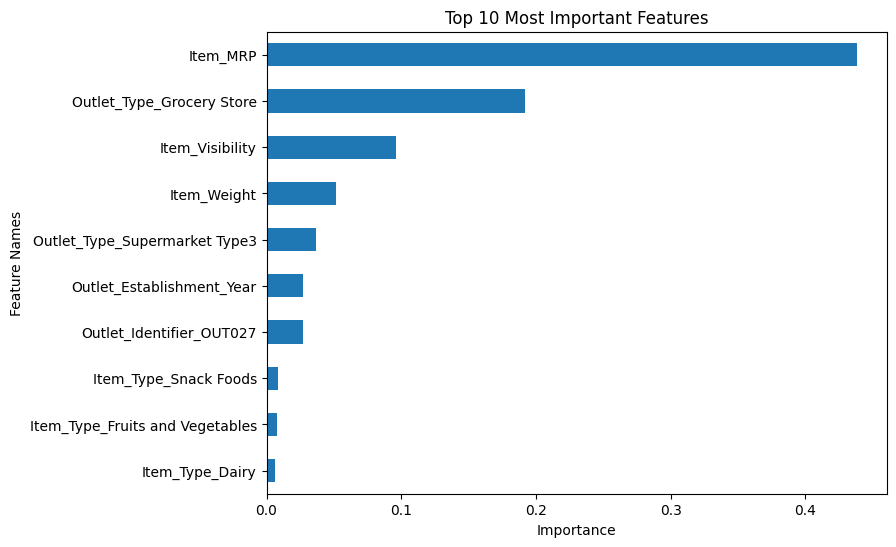

In [179]:
importances = get_importances(reg_seed,sort=True,ascending=False,
                              name="RandomForest Importances")
plot_importance(importances,top_n=10);


In [204]:
importances.sort_values(ascending=False).head(5)

Item_MRP                        0.44
Outlet_Type_Grocery Store       0.19
Item_Visibility                 0.10
Item_Weight                     0.05
Outlet_Type_Supermarket Type3   0.04
Name: Feature Importance, dtype: float64

In [205]:
plot_train = pd.concat([X_train_2,y_train],axis=1)
plot_test = pd.concat([X_test_2,y_test],axis=1)
plot_df = pd.concat([plot_train, plot_test])
plot_df

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,...,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size,Item_Outlet_Sales
4776,0.82,-0.71,1.83,1.33,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.29,515.33
7510,0.56,-1.29,0.60,1.33,0.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.29,"3,056.02"
5828,-0.13,1.81,0.24,0.14,0.00,0.00,1.00,0.00,0.00,0.00,...,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.29,"1,577.95"
5327,-1.17,-1.00,-0.95,0.73,0.00,1.00,0.00,0.00,0.00,1.00,...,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,-1.38,"1,331.60"
4810,1.53,-0.97,-0.34,0.49,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.29,"1,687.14"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4753,1.11,-1.13,0.47,-1.29,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.96,"3,793.73"
4836,-0.64,-1.29,0.02,1.09,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.29,"2,410.86"
8064,-1.14,1.22,1.09,0.49,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.29,"5,309.76"
4418,-1.50,-0.78,-0.37,0.14,0.00,1.00,0.00,0.00,0.00,0.00,...,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.29,"2,530.71"


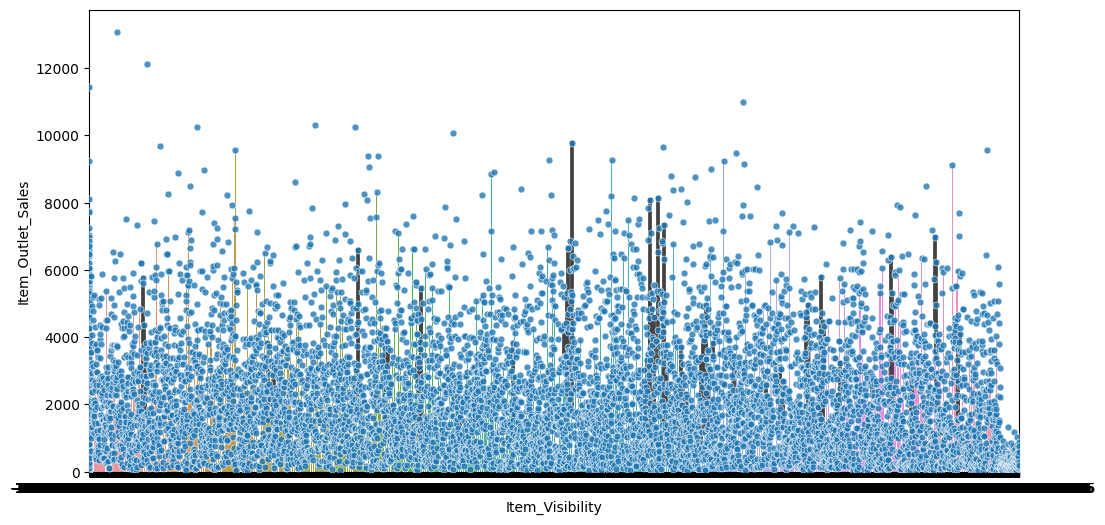

In [217]:
# adding a swarmplot to visualize each point
plt.figure(figsize=(12,6))
sns.stripplot(data=plot_df, x='Item_Visibility',y='Item_Outlet_Sales',size=5,edgecolor='white',
              linewidth=0.5, alpha=.8);
sns.barplot(data=plot_df, x='Item_Visibility',y='Item_Outlet_Sales');

In [219]:
example_tree =  reg_seed.estimators_[0]
example_tree

DecisionTreeRegressor(max_features=1.0, random_state=1657633780)

In [220]:
evaluate_regression(example_tree,X_train_2, y_train, X_test_2,y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 401.251
- MSE = 901,058.918
- RMSE = 949.241
- R^2 = 0.696

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 1,045.098
- MSE = 2,200,275.297
- RMSE = 1,483.332
- R^2 = 0.203


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


In [221]:
example_tree.get_depth()


33

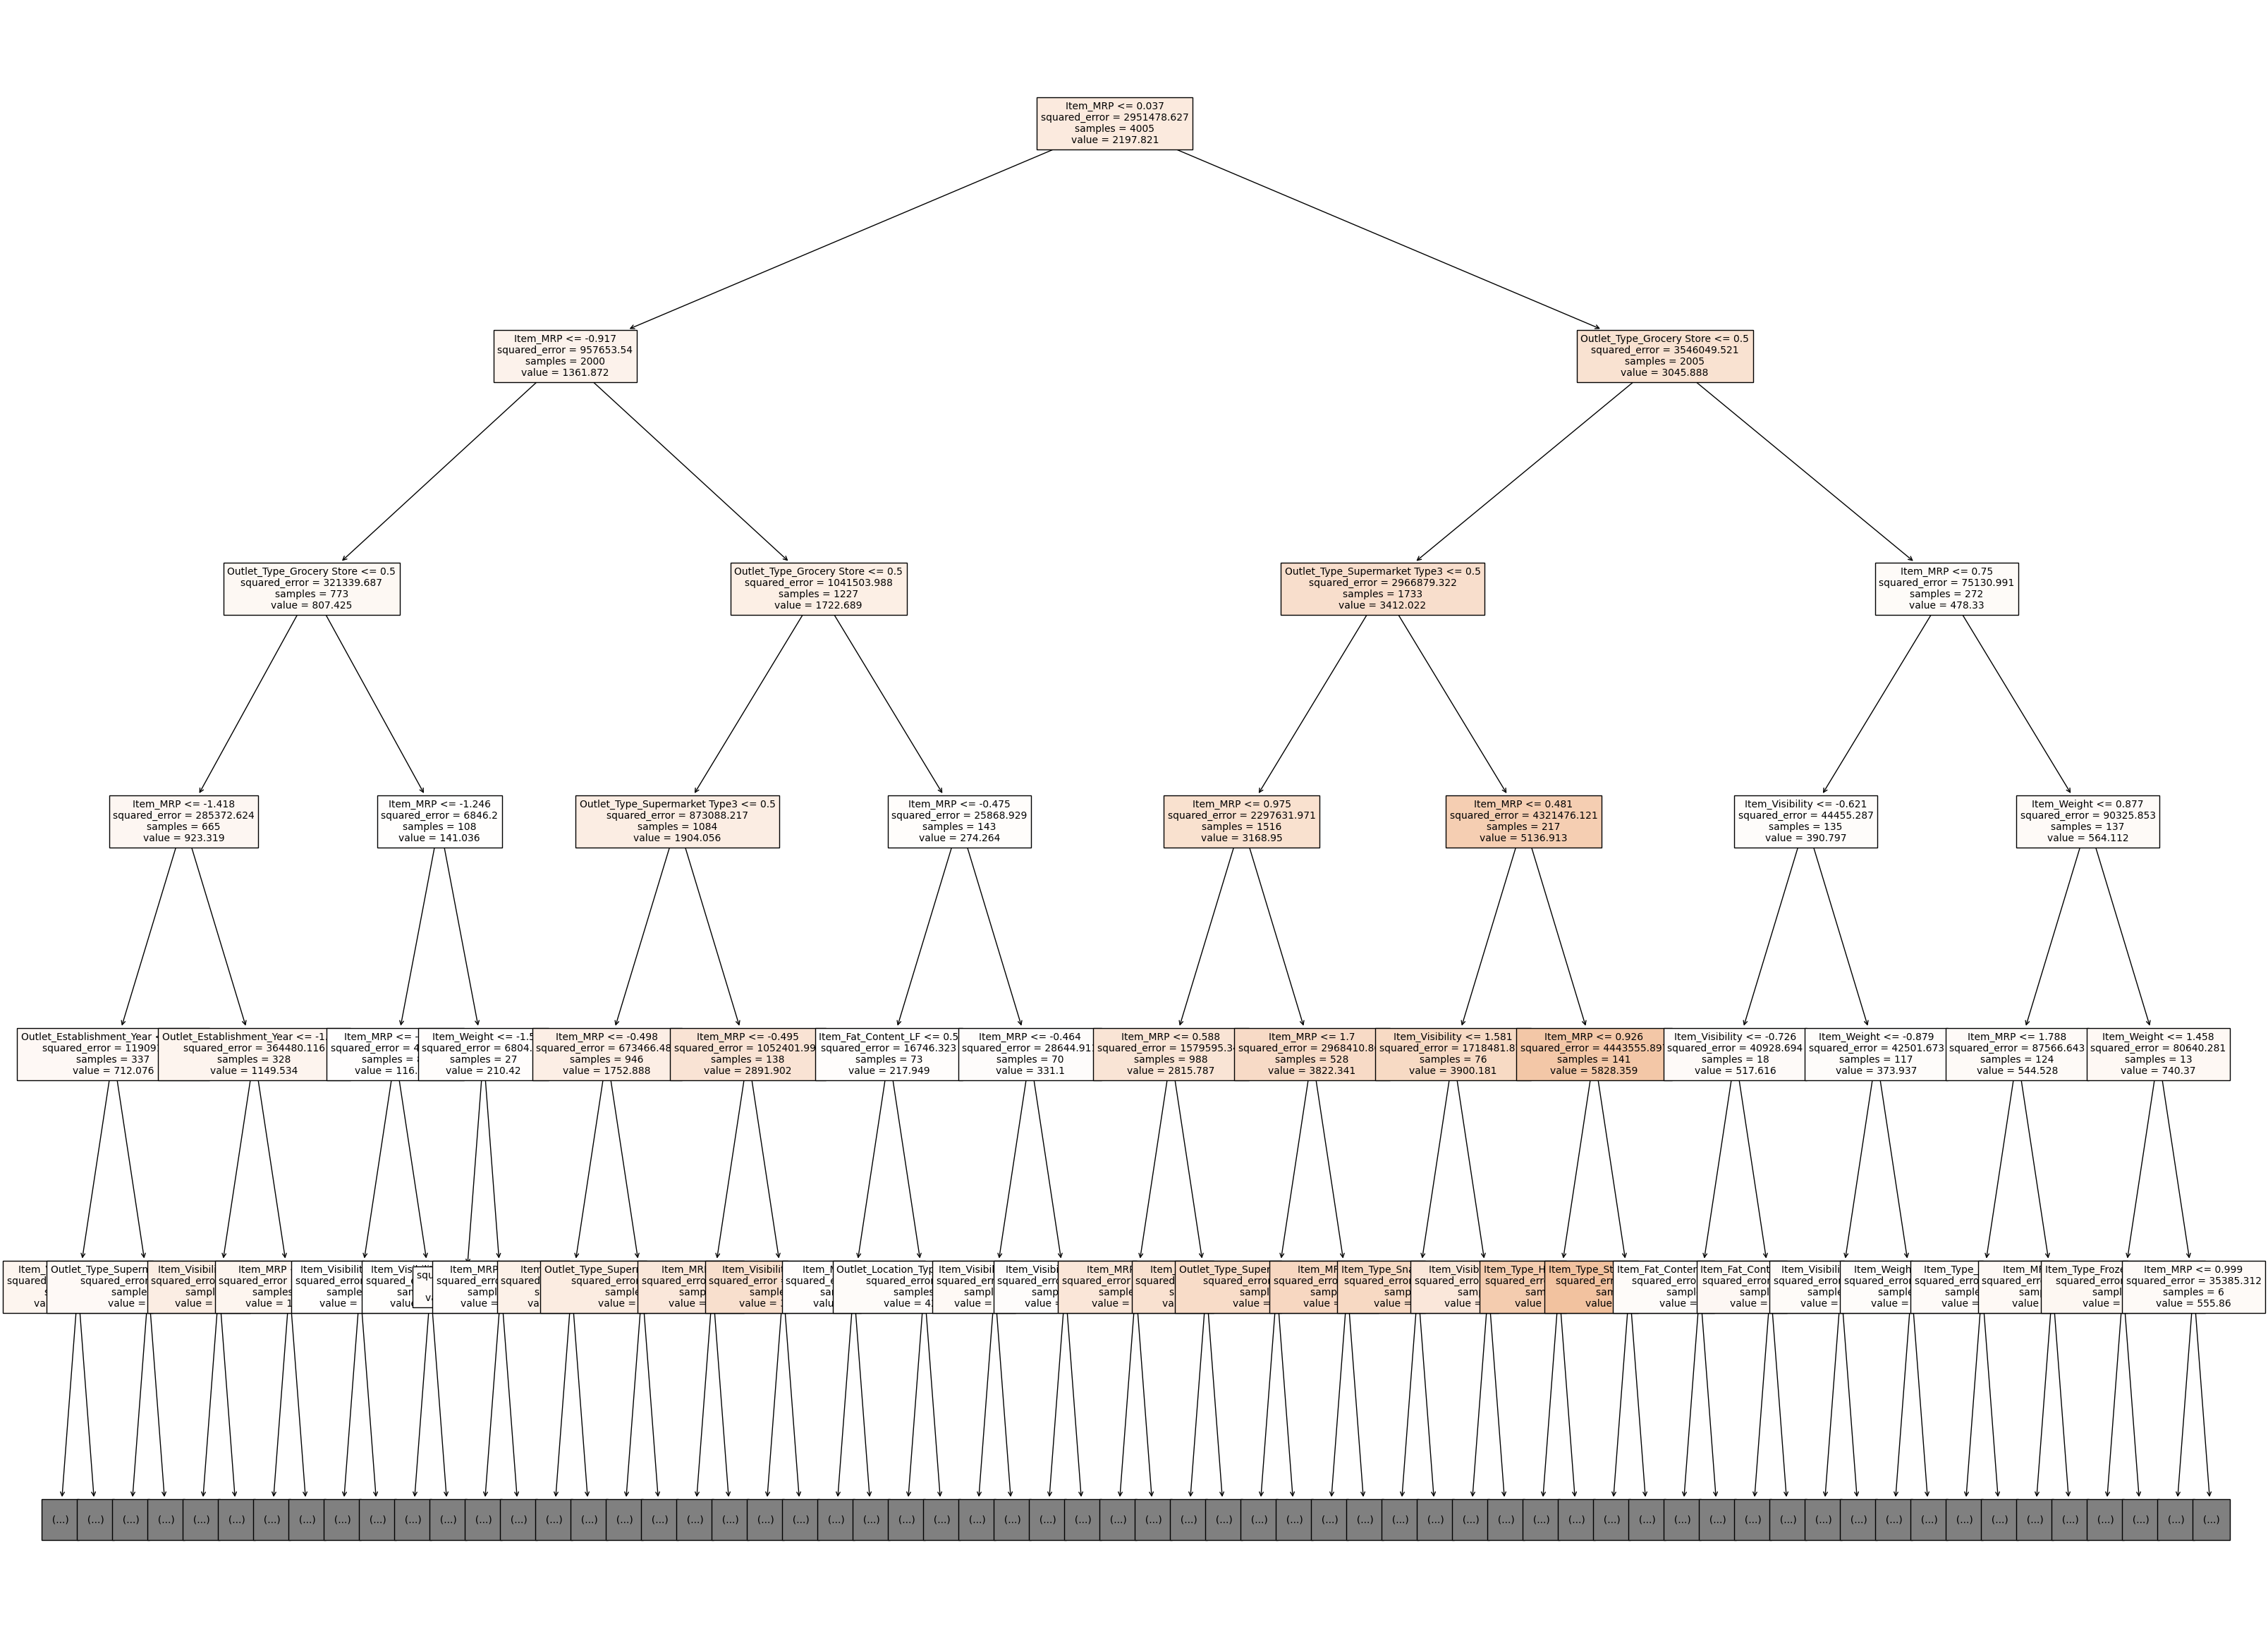

In [227]:
fig, ax = plt.subplots(figsize=(40,30))
plot_tree(example_tree, max_depth=5,filled=True,feature_names=feature_names,ax=ax,
         fontsize=10);

The top 5 most important features are:

1) Item MRP

2) Outlet Type - Grocery Store

3) Item Visibility

4) Item Weight

5) Outlet Type - Supermarket

### Linear Regression

In [182]:
lin_reg.fit(X_train_2, y_train)
evaluate_regression(lin_reg, X_train_2, y_train, X_test_2, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.154
- MSE = 1,297,212.367
- RMSE = 1,138.952
- R^2 = 0.562

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 804.225
- MSE = 1,194,696.265
- RMSE = 1,093.022
- R^2 = 0.567


In [183]:
# Get Coefficients
lin_reg.coef_

array([-8.37242850e+00, -2.19094518e+01,  9.84158452e+02, -1.41827843e+15,
        1.31577833e+14,  1.31577833e+14,  1.31577833e+14,  1.31577833e+14,
        1.31577833e+14, -7.84378216e+13, -7.84378216e+13, -7.84378216e+13,
       -7.84378216e+13, -7.84378216e+13, -7.84378216e+13, -7.84378216e+13,
       -7.84378216e+13, -7.84378216e+13, -7.84378216e+13, -7.84378216e+13,
       -7.84378216e+13, -7.84378216e+13, -7.84378216e+13, -7.84378216e+13,
       -7.84378216e+13, -5.94175480e+12, -1.09656306e+15, -3.75156549e+14,
        9.22152018e+14, -1.20608015e+15, -1.20819872e+15, -1.44695140e+15,
       -1.22021058e+15,  1.02578468e+15,  1.92856872e+15, -5.20069715e+14,
        3.13574201e+15,  1.04169481e+15, -1.91553696e+14, -3.95288839e+14,
        7.39471408e+14, -1.18643722e+15, -3.37893380e+14])

In [184]:
# Saving the coefficients as a pandas series
coeffs = pd.Series(lin_reg.coef_, index = feature_names)
coeffs

Item_Weight                                           -8.37
Item_Visibility                                      -21.91
Item_MRP                                             984.16
Outlet_Establishment_Year         -1,418,278,428,679,293.50
Item_Fat_Content_LF                  131,577,833,027,117.17
Item_Fat_Content_Low Fat             131,577,833,027,175.64
Item_Fat_Content_Regular             131,577,833,027,240.14
Item_Fat_Content_low fat             131,577,833,027,237.06
Item_Fat_Content_reg                 131,577,833,027,132.33
Item_Type_Baking Goods               -78,437,821,559,223.02
Item_Type_Breads                     -78,437,821,559,252.25
Item_Type_Breakfast                  -78,437,821,559,178.05
Item_Type_Canned                     -78,437,821,559,196.89
Item_Type_Dairy                      -78,437,821,559,331.45
Item_Type_Frozen Foods               -78,437,821,559,225.06
Item_Type_Fruits and Vegetables      -78,437,821,559,177.78
Item_Type_Hard Drinks                -78

In [185]:
# use .loc to add the intercept to the series
coeffs.loc['intercept'] = lin_reg.intercept_
coeffs

Item_Weight                                           -8.37
Item_Visibility                                      -21.91
Item_MRP                                             984.16
Outlet_Establishment_Year         -1,418,278,428,679,293.50
Item_Fat_Content_LF                  131,577,833,027,117.17
Item_Fat_Content_Low Fat             131,577,833,027,175.64
Item_Fat_Content_Regular             131,577,833,027,240.14
Item_Fat_Content_low fat             131,577,833,027,237.06
Item_Fat_Content_reg                 131,577,833,027,132.33
Item_Type_Baking Goods               -78,437,821,559,223.02
Item_Type_Breads                     -78,437,821,559,252.25
Item_Type_Breakfast                  -78,437,821,559,178.05
Item_Type_Canned                     -78,437,821,559,196.89
Item_Type_Dairy                      -78,437,821,559,331.45
Item_Type_Frozen Foods               -78,437,821,559,225.06
Item_Type_Fruits and Vegetables      -78,437,821,559,177.78
Item_Type_Hard Drinks                -78

In [186]:
# fitting a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_2, y_train)
evaluate_regression(lin_reg, X_train_2, y_train, X_test_2,y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.154
- MSE = 1,297,212.367
- RMSE = 1,138.952
- R^2 = 0.562

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 804.225
- MSE = 1,194,696.265
- RMSE = 1,093.022
- R^2 = 0.567


In [187]:
# Otain preprocessed feature names
lin_reg.feature_names_in_

array(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Fat_Content_LF',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Item_Fat_Content_low fat', 'Item_Fat_Content_reg',
       'Item_Type_Baking Goods', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT010', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018',
       'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027',
       'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045',
       'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049',
       'Outlet_Lo

In [188]:
# Saving the coefficients
coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
coeffs['intercept'] = lin_reg.intercept_
coeffs

Item_Weight                                           -8.37
Item_Visibility                                      -21.91
Item_MRP                                             984.16
Outlet_Establishment_Year         -1,418,278,428,679,293.50
Item_Fat_Content_LF                  131,577,833,027,117.17
Item_Fat_Content_Low Fat             131,577,833,027,175.64
Item_Fat_Content_Regular             131,577,833,027,240.14
Item_Fat_Content_low fat             131,577,833,027,237.06
Item_Fat_Content_reg                 131,577,833,027,132.33
Item_Type_Baking Goods               -78,437,821,559,223.02
Item_Type_Breads                     -78,437,821,559,252.25
Item_Type_Breakfast                  -78,437,821,559,178.05
Item_Type_Canned                     -78,437,821,559,196.89
Item_Type_Dairy                      -78,437,821,559,331.45
Item_Type_Frozen Foods               -78,437,821,559,225.06
Item_Type_Fruits and Vegetables      -78,437,821,559,177.78
Item_Type_Hard Drinks                -78

In [189]:
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
coeff_rank

Outlet_Location_Type_Tier 2       44.00
Outlet_Identifier_OUT049          43.00
Outlet_Identifier_OUT035          42.00
Outlet_Establishment_Year         41.00
Outlet_Identifier_OUT045          40.00
Outlet_Identifier_OUT027          39.00
Outlet_Identifier_OUT019          38.00
Outlet_Type_Supermarket Type3     37.00
Outlet_Identifier_OUT013          36.00
Outlet_Location_Type_Tier 3       35.00
Outlet_Identifier_OUT046          34.00
Outlet_Identifier_OUT018          33.00
intercept                         32.00
Outlet_Type_Supermarket Type2     31.00
Outlet_Location_Type_Tier 1       30.00
Outlet_Type_Supermarket Type1     29.00
Outlet_Identifier_OUT017          28.00
Outlet_Size                       27.00
Outlet_Type_Grocery Store         26.00
Item_Fat_Content_Regular          25.00
Item_Fat_Content_low fat          24.00
Item_Fat_Content_Low Fat          23.00
Item_Fat_Content_reg              22.00
Item_Fat_Content_LF               21.00
Item_Type_Dairy                   20.00


In [190]:
top_n_features = coeff_rank.head(10)
top_n_features

Outlet_Location_Type_Tier 2     44.00
Outlet_Identifier_OUT049        43.00
Outlet_Identifier_OUT035        42.00
Outlet_Establishment_Year       41.00
Outlet_Identifier_OUT045        40.00
Outlet_Identifier_OUT027        39.00
Outlet_Identifier_OUT019        38.00
Outlet_Type_Supermarket Type3   37.00
Outlet_Identifier_OUT013        36.00
Outlet_Location_Type_Tier 3     35.00
dtype: float64

In [191]:
# Slicing out the top_n_features names to visualize
plot_vals = coeffs.loc[top_n_features.index]
plot_vals


Outlet_Location_Type_Tier 2      3,135,742,007,298,977.50
Outlet_Identifier_OUT049         1,928,568,718,537,006.75
Outlet_Identifier_OUT035        -1,446,951,395,439,056.00
Outlet_Establishment_Year       -1,418,278,428,679,293.50
Outlet_Identifier_OUT045        -1,220,210,583,287,014.50
Outlet_Identifier_OUT027        -1,208,198,720,998,586.50
Outlet_Identifier_OUT019        -1,206,080,147,221,315.00
Outlet_Type_Supermarket Type3   -1,186,437,219,504,717.00
Outlet_Identifier_OUT013        -1,096,563,062,071,492.75
Outlet_Location_Type_Tier 3      1,041,694,808,260,494.12
dtype: float64

In [192]:
top_n = 10
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
top_n_features = coeff_rank.head(top_n).index
plot_vals = coeffs.loc[top_n_features].sort_values()
plot_vals

Outlet_Identifier_OUT035        -1,446,951,395,439,056.00
Outlet_Establishment_Year       -1,418,278,428,679,293.50
Outlet_Identifier_OUT045        -1,220,210,583,287,014.50
Outlet_Identifier_OUT027        -1,208,198,720,998,586.50
Outlet_Identifier_OUT019        -1,206,080,147,221,315.00
Outlet_Type_Supermarket Type3   -1,186,437,219,504,717.00
Outlet_Identifier_OUT013        -1,096,563,062,071,492.75
Outlet_Location_Type_Tier 3      1,041,694,808,260,494.12
Outlet_Identifier_OUT049         1,928,568,718,537,006.75
Outlet_Location_Type_Tier 2      3,135,742,007,298,977.50
dtype: float64

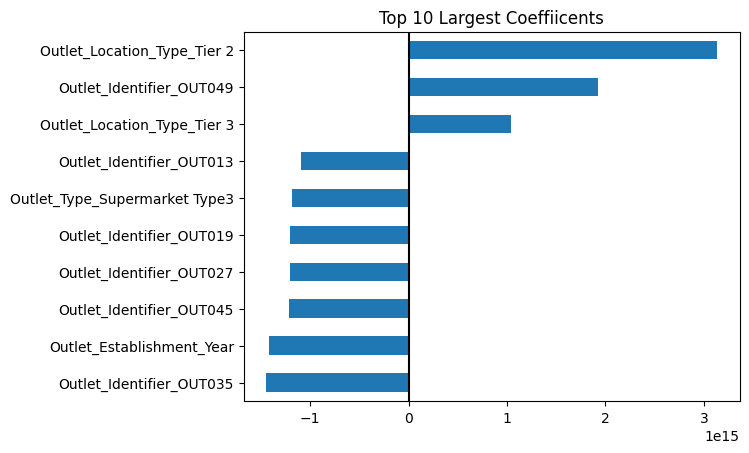

In [193]:
## Plot the coefficients
ax = plot_vals.sort_values().plot(kind='barh')#,figsize=(5,6))
ax.axvline(0,color='k')
ax.set_title(f'Top {top_n} Largest Coeffiicents');